In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
def f(x):
    return 3*x**2 + 2*x + 1

In [82]:
f(1)

6

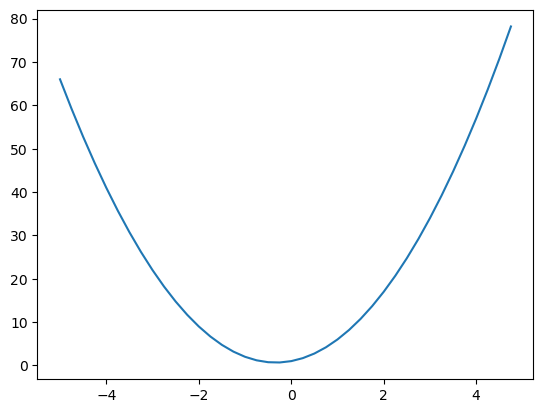

In [83]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

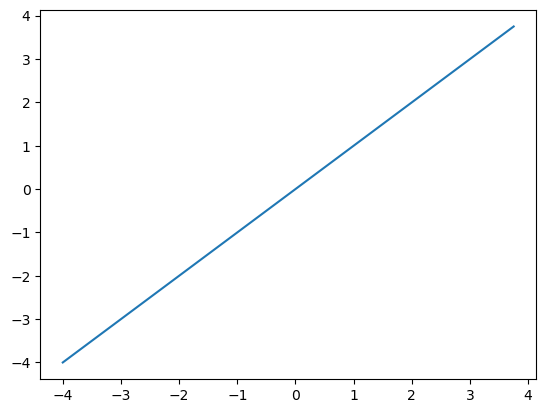

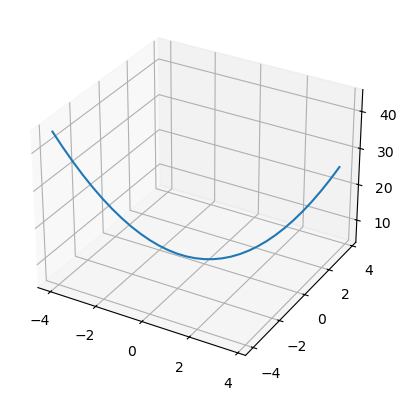

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3

def g(x,y):
    return (x-2)**2 + (y+1)**2

xs = np.arange(-4, 4, 0.25)
ys = np.arange(-4, 4, 0.25)
zs = g(xs,ys)
plt.plot(xs, ys)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(xs,ys,zs)



In [84]:
h = 0.001
x = 3
(f(x+h) - f(x)) / h

a = 1
b = 2
c = 3
d1 = a*b + c
a += h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("slope = ", (d2 - d1) / h)

d1 =  5
d2 =  5.002
slope =  1.9999999999997797


In [85]:
import math


class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self._label = label

    def __repr__(self):
        return f"Value(data={self.data}, _prev={self._prev}, _op={self._op}, _label={self._label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __neg__(self):
        return self * -1
    
    def tanh(self):
        x = self.data
        tanh_x = (math.e**(2*x) - 1) / (math.e**(2*x) + 1)
        # Alternatively, math.exp(2*x)
        out = Value(tanh_x, (self,), 'tanh')

        def _backward():
            self.grad += (1 - tanh_x**2) * out.grad
        out._backward = _backward 
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    # def backward(self):
    #     self._backward()
    #     for v in self._prev:
    #         v.backward()
    
    def backward(self):
        topo = [] 
        visited = set()
        def _build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    _build_topo(child)
                topo.append(v)
        
        _build_topo(self)
        for v in topo:
            v.grad = 0.0
        
        self.grad = 1.0
        
        for v in reversed(topo):
            v._backward()

a = Value(1, label='a')
b = Value(2, label='b')
c = Value(3, label='c')
d = Value(-4.05, label='d')
e = a*b ; e._label = 'e'
f = e + c ; f._label = 'f'
L = d * f; L._label = 'L'
T = L.tanh(); T._label = 'T'
test = Value(0.5)
# print(test.tanh())
g = a + 1; g._label = 'g'
# print(g)
h = a.exp(); h._label = 'h'
# print(h)
i = a/b; i._label = 'i'
# print(i)
j = b - a; j._label = 'j'
# print(j)
# j = 1 - a; j._label = 'j'
j = -j
print(j)

Value(data=-1, _prev={Value(data=1, _prev={Value(data=-1, _prev={Value(data=-1, _prev=set(), _op=, _label=), Value(data=1, _prev=set(), _op=, _label=a)}, _op=*, _label=), Value(data=2, _prev=set(), _op=, _label=b)}, _op=+, _label=j), Value(data=-1, _prev=set(), _op=, _label=)}, _op=*, _label=)


In [86]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(comment='Computation Graph', format='svg', graph_attr={'rankdir': 'LR'})
    for n in nodes:
        dot.node(name=str(id(n)), label=f"{n._label} | data: {n.data:.4f} | grad: {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=f"{n._op}", shape='record')
            dot.edge(str(id(n)) + n._op, str(id(n)))
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [87]:
d.grad = 5.0
f.grad = -4.05

e.grad = -4.05
c.grad = -4.05

a.grad = -4.05 * 2
b.grad = -4.05 * 1

def playground ():
    h = 0.001

    a = 1.0
    b = 2.0
    c = 3.0
    d = -4.05
    d += h
    e = a*b
    f = e + c 
    L1 =  d * f

    a = 1.0
    b = 2.0
    c = 3.0
    d = -4.05
    e = a*b
    f = e + c 
    L2 =  d * f

    print(L1)
    print(L2)
    print((L1 - L2) / h)

playground()

-20.244999999999997
-20.25
5.000000000002558


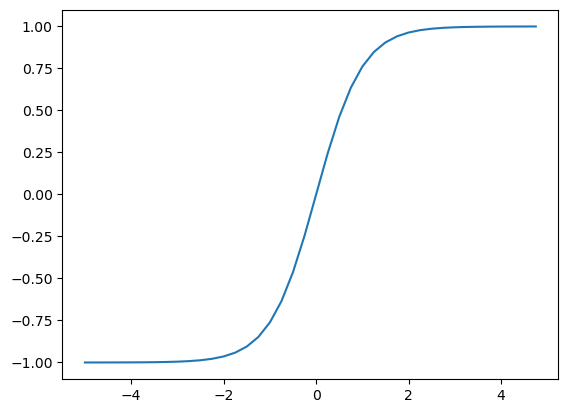

In [88]:
# Plot out tanh
xs = np.arange(-5, 5, 0.25)
ys = np.tanh(xs)
plt.plot(xs, ys)

# Build standard backpropagation directed graph
# Formula: x1*w1 + x2*w2 + b = o(utput)


In [89]:
x1 = Value(0.0, label='x1')
w1 = Value(1.0, label='w1')
x2 = Value(2.0, label='x2')
w2 = Value(-3.0, label='w2')
b = Value(5.88, label='b')
x1w1 = x1*w1; x1w1._label = 'x1w1'
x2w2 = x2*w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'; o.grad = 1.0
print(o)
p = ((2 * n).exp() - 1) / ((2 * n).exp() + 1); p._label = 'p'; p.grad = 1.0
# e = (2 * n).exp(); e._label = 'e'; e.grad = 1.0
# nom = e - 1; nom._label = 'nom'
# print(f'nom: {nom}')
# denom = e + 1; denom._label = 'denom'
# print(f'denom: {denom}')
# res = nom / denom; res._label = 'res'
# print(f'res: {res}')
# print (e)
# print(f'nom: {math.e ** (2 * n.data) - 1}')
# print(f'denom: {math.e ** (2 * n.data) + 1}')
# print(f'res: {( math.e ** (2 * n.data) - 1) / ( math.e ** (2 * n.data) + 1 )}')
print(p)

# n.grad = 1 - o.data**2
# b.grad = n.grad
# x1w1x2w2.grad = n.grad
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad 
# x1.grad = w1.data * x1w1.grad
# w2.grad = x1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# print(x1w1)
# print(x2w2)
# print(x1w1x2w2)
# print(n)
# print(o)
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# o.backward()
o.topo_backward()
draw_dot(o)
# p.topo_backward()
# draw_dot(p)




# do/dn = 1-tanh(n)**2 = 1-o**2  = 1 - 1**2  = 0

Value(data=-0.11942729853438598, _prev={Value(data=-0.1200000000000001, _prev={Value(data=-6.0, _prev={Value(data=0.0, _prev={Value(data=0.0, _prev=set(), _op=, _label=x1), Value(data=1.0, _prev=set(), _op=, _label=w1)}, _op=*, _label=x1w1), Value(data=-6.0, _prev={Value(data=2.0, _prev=set(), _op=, _label=x2), Value(data=-3.0, _prev=set(), _op=, _label=w2)}, _op=*, _label=x2w2)}, _op=+, _label=x1w1x2w2), Value(data=5.88, _prev=set(), _op=, _label=b)}, _op=+, _label=n)}, _op=tanh, _label=o)
Value(data=-0.11942729853438597, _prev={Value(data=0.5597136492671929, _prev={Value(data=1.7866278610665534, _prev={Value(data=1, _prev=set(), _op=, _label=), Value(data=0.7866278610665532, _prev={Value(data=-0.2400000000000002, _prev={Value(data=2, _prev=set(), _op=, _label=), Value(data=-0.1200000000000001, _prev={Value(data=-6.0, _prev={Value(data=0.0, _prev={Value(data=0.0, _prev=set(), _op=, _label=x1), Value(data=1.0, _prev=set(), _op=, _label=w1)}, _op=*, _label=x1w1), Value(data=-6.0, _prev=

AttributeError: 'Value' object has no attribute 'topo_backward'

In [ ]:
import torch

# x1 = torch.Tensor([2.0])
# x1Double = x1.double()
# print(x1)
# print(x1.dtype)
# print(x1Double)

# matrix = torch.Tensor([[1, 2, 3], [4, 5, 6]])
# print(matrix)
# print(matrix.shape)
# x1 = Value(0.0, label='x1')
# w1 = Value(1.0, label='w1')
# x2 = Value(2.0, label='x2')
# w2 = Value(-3.0, label='w2')
# b = Value(5.88, label='b')
# x1w1 = x1*w1; x1w1._label = 'x1w1'
# x2w2 = x2*w2; x2w2._label = 'x2w2'
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
# n = x1w1x2w2 + b; n._label = 'n'
# o = n.tanh(); o._label = 'o'; o.grad = 1.0

x1 = torch.Tensor([0.0]); x1.requires_grad = True
w1 = torch.Tensor([1.0]); w1.requires_grad = True
x2 = torch.Tensor([2.0]); x2.requires_grad = True
w2 = torch.Tensor([-3.0]); w2.requires_grad = True
b = torch.Tensor([5.88]); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = n.tanh()
print(o.data.item())
o.backward()
# print(o.grad)

print(n)
print(o)

print(x1.grad)
print(w1.grad)
print(x2.grad)
print(w2.grad)
print(b.grad)



-0.11942718923091888
tensor([-0.1200], grad_fn=<AddBackward0>)
tensor([-0.1194], grad_fn=<TanhBackward0>)
tensor([0.9857])
tensor([0.])
tensor([-2.9572])
tensor([1.9715])
tensor([0.9857])


In [ ]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        zip_output = zip(self.w, x)
        wrapped_zip_output = list(zip_output)
        act = sum((wi*xi for wi,xi in wrapped_zip_output),self.b)
        return act.tanh()
        # return sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs if len(outs) > 1 else outs[0]
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
# x = [2.0, 3.0]
# n = Neuron(2)
# print(n(x))

# l = Layer(2, 3)
# l(x)



In [326]:
x = [2.0, 3.0, -4.0]
mlp = MLP(3, [4, 4, 1])
out = mlp(x)  
# draw_dot(out)
len(mlp.parameters())

41

In [327]:
xs = [
    [2.0, 3.0, -4.0],
    [1.0, -3.0, -2.0],
    [3.0, -1.0, 2.0],
    [4.0, 2.0, -3.0]
]
ys = [1.0, -1.0, -1.0, 1.0]



In [328]:
for i in range(20):
    # Forward pass
    ypred = [mlp(x) for x in xs]
    loss = [(ygt - yout)**2 for ygt, yout in zip(ys, ypred)]
    total_loss = sum(loss)
    
    # Backward pass
    total_loss.backward()
    
    # Update weights
    step_size = 0.05
    for p in mlp.parameters():
        p.data += -step_size * p.grad
    
    print(i, total_loss.data)

# total_loss.grad = 1.0
# total_loss.backward()
# draw_dot(total_loss)
# mlp.layers[0].neurons[0].w[0].grad

0 3.579293924280692
1 0.7196751551157488
2 0.33009243894579854
3 0.2132075464926445
4 0.15710450766892775
5 0.12430016382637732
6 0.10279158024473044
7 0.08760295786330964
8 0.07630601268525809
9 0.0675753314650962
10 0.06062611476625126
11 0.05496400961924191
12 0.05026209693259175
13 0.04629552482212006
14 0.04290455284660174
15 0.03997257188223151
16 0.03741246642271888
17 0.035157844432497296
18 0.033157221355420624
19 0.03137005888726499


In [334]:
print(ypred)
print([pred.data for pred in ypred])

[Value(data=0.9314216552360255, _prev={Value(data=1.6690174043822665, _prev={Value(data=1.7479684418096546, _prev={Value(data=1.810772186096115, _prev={Value(data=1.119034801676011, _prev={Value(data=-1.2394705180135908, _prev=set(), _op=, _label=), Value(data=-0.9067412838469247, _prev={Value(data=-1.5088867024292372, _prev={Value(data=-1.3911982913750114, _prev={Value(data=0.263642538512984, _prev={Value(data=0.3640263365931171, _prev={Value(data=0.38151949691230946, _prev={Value(data=-1.9425039245757163, _prev={Value(data=0.7195556701865163, _prev={Value(data=-0.9153928324576481, _prev=set(), _op=, _label=), Value(data=1.6348829244099705, _prev={Value(data=2.0, _prev=set(), _op=, _label=), Value(data=0.8173203623796241, _prev=set(), _op=, _label=)}, _op=*, _label=)}, _op=+, _label=), Value(data=-2.6620595947622325, _prev={Value(data=-0.8877401071196079, _prev=set(), _op=, _label=), Value(data=3.0, _prev=set(), _op=, _label=)}, _op=*, _label=)}, _op=+, _label=), Value(data=2.32402342